# GHG emissions of the EU and its member states since 1990

This notebooks details the data preparation and plotting of chart showing the evolution of greenhouse gas emissions EU member states and the EU as whole over time.

## Load prerequisities

This notebooks uses the Tidyverse libraries, `patchwork` and the `eurostat` package. To install these libraries, run the command `install.packages(c("eurostat", "patchwork", "tidyverse"))` in your R instance.

In [41]:
library(eurostat)
library(patchwork)
library(tidyverse)

theme_set(theme_minimal())

# Load our library with predefined categories of GHG emissions
# based on CRF codes.
source("../lib/R/emissions-utils.r")


## Parameters

In [42]:
first_year <- 1990
last_year <- 2023
# Change to a country code string in order to generate plots for a given
# country only.
selected_country <- NULL

eu27_codes <- eu_countries$code
assertthat::assert_that(length(eu27_codes) == 27)

# Imported from emissions-utils.r above.
category_colours <- emission_category_colours

year_axis_title <- "Rok"
total_emissions_axis_title <- "Celkové emise skleníkových plynů (mil. t CO₂eq/rok)"
emissions_change_axis_title <- "Změna v emisích oproti roku 1990"


[1] TRUE

## Emissions data

This visualization uses the [Greenhouse gas emissions by source sector](https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE) dataset from EEA/Eurostat (product code `env_air_gge`).

In [ ]:
# Download and filter data for all countries, selected sectors and years.
eu_emissions <-
  get_eurostat("env_air_gge",
               filters = list(airpol  = "GHG",
                              geo     = eu27_codes,
                              unit    = "MIO_T"),
               time_format = "num") |>
  select(CountryCode = geo,
         Year        = time,
         Code        = src_crf,
         Value       = values) |>
  filter(between(Year, first_year, last_year)) |>
  replace_na(list(Value = 0)) |>
  fakta_calculate_emission_categories(Value) |>
  arrange(CountryCode, Year)


We now have a table of annual emissions per country, year and source category in a long format:

In [44]:
head(eu_emissions)

CountryCode,Year,Category,Value
<chr>,<dbl>,<chr>,<dbl>
AT,1990,PowerHeat,11.09819
AT,1990,Industry,27.33154
AT,1990,Transport,14.60948
AT,1990,Buildings,12.91843
AT,1990,Agriculture,9.94951
AT,1990,Waste,4.56455


In [ ]:
# Filter data down to a single country (or a group of countries)
# if requested.
selected_emissions <-
  (if (is.character(selected_country)) {
    filter(eu_emissions, CountryCode %in% selected_country)
  } else {
    eu_emissions
  }) |>
  summarise(Value = sum(Value, na.rm = TRUE), .by = c(Year, Category)) |>
  group_by(Category) |>
  mutate(ChangePct_1990 = Value / Value[1] - 1) |>
  ungroup() |>
  # Sort categories by share in the last year.
  mutate(Category = fct_reorder2(Category, Year, Value))

The following table summarises total emissions and relative changes since 1990 in the selected region in the last year:

In [52]:
filter(selected_emissions, Year == max(Year)) |>
  mutate(ChangePct_1990 = 100 * ChangePct_1990,
         across(3:4, ~ round(.x, 1)))

Year,Category,Value,ChangePct_1990
<dbl>,<fct>,<dbl>,<dbl>
2023,PowerHeat,575.3,-53.3
2023,Industry,807.8,-48.0
2023,Transport,912.9,26.3
2023,Buildings,370.2,-40.5
2023,Agriculture,439.8,-24.3
2023,Waste,108.5,-41.3
2023,Other,13.9,-53.9


The next table lists the total emissions in the first and last year:

In [53]:
filter(selected_emissions, Year %in% range(Year)) |>
  summarise(Total = sum(Value) |> round(1), .by = Year)

Year,Total
<dbl>,<dbl>
1990,4927.2
2023,3228.3


## Overall emissions

The overall emissions of the EU or a counry are plotted as a stacked area chart with individual sectors denoted by different colours (defined above).

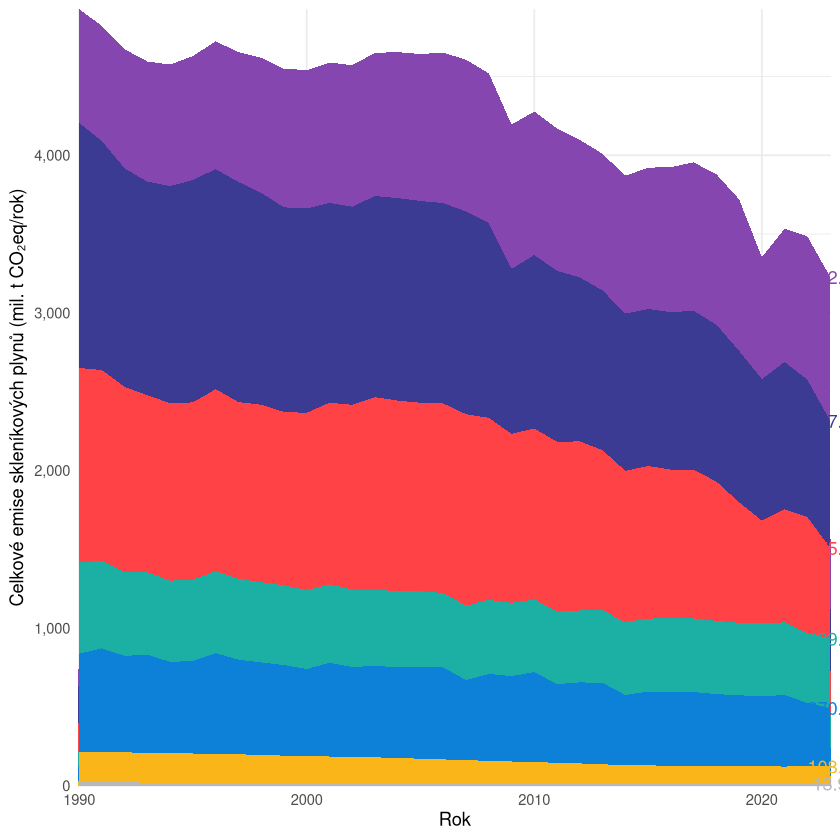

In [54]:
stacked_area <- selected_emissions |>
  ggplot(aes(Year, Value)) +
  geom_area(aes(fill = Category)) +
  geom_text(aes(colour = Category, label = round(Value, 1)),
            data = ~ filter(.x, Year == max(Year)),
            position = "stack") +
  scale_colour_manual(values = category_colours) +
  scale_fill_manual(values = category_colours) +
  scale_y_continuous(labels = scales::label_comma()) +
  coord_cartesian(clip = "off", expand = FALSE) +
  labs(x = year_axis_title,
       y = total_emissions_axis_title) +
  theme(panel.grid.minor.x = element_blank(),
        legend.position    = "none")

stacked_area

## Emissions change by category

Relative changes within a category are plotted as small multiples of line charts.

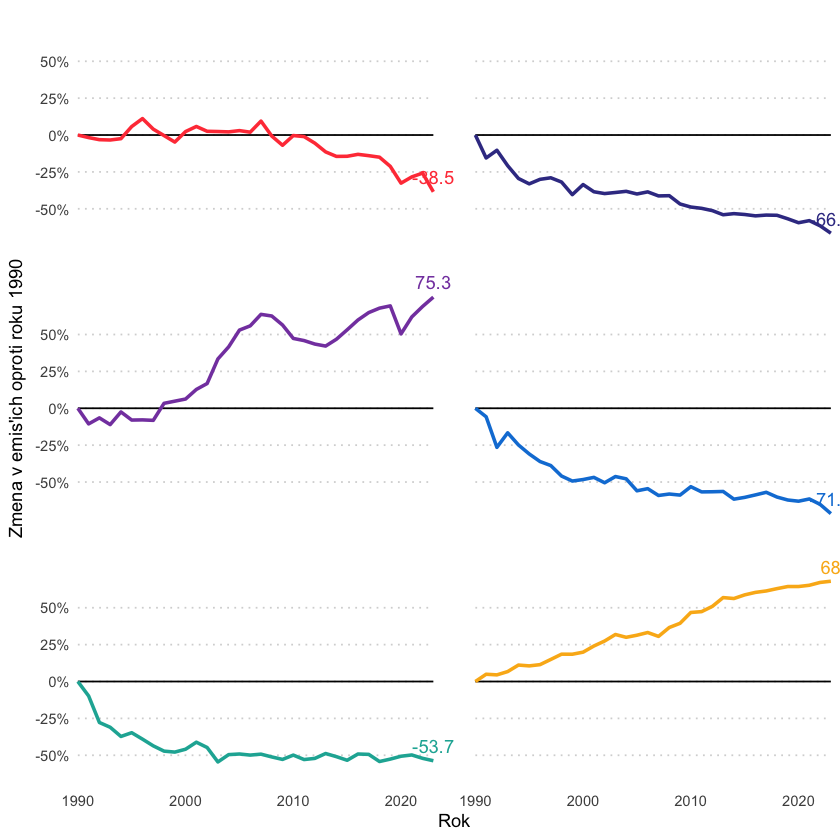

In [55]:
small_multiples <- selected_emissions |>
  filter(Category != "Other") |>
  ggplot(aes(Year, ChangePct_1990)) +
  geom_hline(yintercept = 0) +
  geom_line(aes(colour = Category), linewidth = 1) +
  geom_text(aes(colour = Category, label = round(100 * ChangePct_1990, 1)),
            data = ~ filter(.x, Year == max(Year)),
            nudge_y = .1) +
  scale_colour_manual(values = category_colours, guide = "none") +
  scale_y_continuous(labels = scales::label_percent(),
                     breaks = seq(-.5, .5, .25)) +
  coord_cartesian(clip = "off", expand = FALSE) +
  facet_wrap(vars(Category), ncol = 2) +
  labs(x = year_axis_title,
       y = emissions_change_axis_title) +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.major.y = element_line(colour   = scales::alpha("black", .2),
                                          linetype = 3),
        panel.grid.minor.y = element_blank(),
        panel.spacing      = unit(.05, "npc"),
        strip.text         = element_blank())

small_multiples

## SVG exports

The following code exports the two charts side-by-side into a single SVG file for further use:

In [ ]:
svglite::svglite("../outputs/emissions-over-time-eu.svg", width = 12, height = 8)
stacked_area + small_multiples + plot_layout(widths = c(4, 3))
dev.off()

pdf 
  2